In [1]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent','Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                           download=True, transform=transform)

test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                          download=True, transform=transform)

In [3]:
num_workers = 0
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers=num_workers)

# Visualize the Data

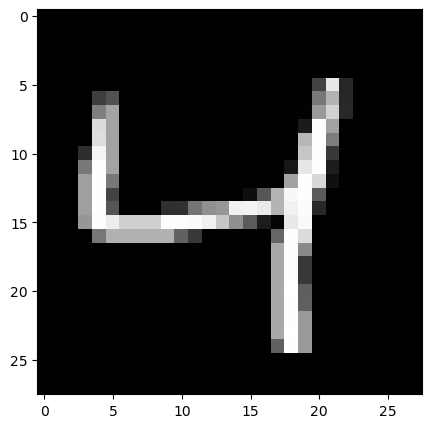

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

img = np.squeeze(images[2])
fig = plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Convolutional Autoencoder

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1,16,3, padding=1)
        self.conv2 = nn.Conv2d(16,4,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
        return x
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


# Training Autoencoder

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 30
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss / len(train_loader)
    print('Epoch: {} \t Training LOss: {:.6f}'.format(
        epoch, 
        train_loss
    ))

/home/bish/.local/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	 Training LOss: 0.567896
Epoch: 2 	 Training LOss: 0.283595
Epoch: 3 	 Training LOss: 0.263560
Epoch: 4 	 Training LOss: 0.246987
Epoch: 5 	 Training LOss: 0.228386
Epoch: 6 	 Training LOss: 0.213783
Epoch: 7 	 Training LOss: 0.205917
Epoch: 8 	 Training LOss: 0.201774
Epoch: 9 	 Training LOss: 0.198937
Epoch: 10 	 Training LOss: 0.195935
Epoch: 11 	 Training LOss: 0.193928
Epoch: 12 	 Training LOss: 0.192505
Epoch: 13 	 Training LOss: 0.191366
Epoch: 14 	 Training LOss: 0.190414
Epoch: 15 	 Training LOss: 0.189611
Epoch: 16 	 Training LOss: 0.188930
Epoch: 17 	 Training LOss: 0.188374
Epoch: 18 	 Training LOss: 0.187892
Epoch: 19 	 Training LOss: 0.187482
Epoch: 20 	 Training LOss: 0.187099
Epoch: 21 	 Training LOss: 0.186711
Epoch: 22 	 Training LOss: 0.186397
Epoch: 23 	 Training LOss: 0.186096
Epoch: 24 	 Training LOss: 0.185802
Epoch: 25 	 Training LOss: 0.185513
Epoch: 26 	 Training LOss: 0.185235
Epoch: 27 	 Training LOss: 0.184981
Epoch: 28 	 Training LOss: 0.184733
E

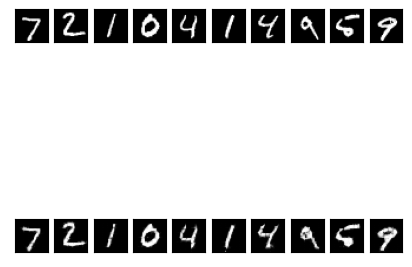

In [10]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

output = model(images)
images = images.numpy()

output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize = (5,5))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)